# 🚀 REVENUE FORECASTING - SIMPLIFIED & EXPLAINABLE MODEL

## DESIGN PHILOSOPHY:
**Use ONLY simple, human-understandable features that business stakeholders can explain.**

## KEY INSIGHT ON SIMULATION:
The critical issue with YoY features is understanding the SOURCE of the value:

- For `revenue_lag_12` feature in April 2025:
  - This feature means "revenue from 12 months ago"
  - 12 months before April 2025 = April 2024
  - So we need April 2024's **actual_revenue** (NOT April 2024's revenue_lag_12!)
  - If we used April 2024's revenue_lag_12, we'd get April 2023's revenue (lag of lag = 24 months)

- For `signed_density` feature in April 2025:
  - Use April 2024's **signed_density** value (this is correct as-is)

## SIMULATION STRATEGIES:
1. **yoy_fill_from_source**: Map feature → source column from last year
2. **ewm_6**: Dynamic EWM using rolling window including simulated months
3. **forward_fill**: Use last known actual value

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
print('✅ Libraries imported!')

✅ Libraries imported!


In [2]:
# Load data
df = pd.read_csv('mon_final.csv', index_col=0)
df = df.sort_values(['year', 'month_num']).reset_index(drop=True)
print(f'Dataset shape: {df.shape}')
print(f'Years: {sorted(df["year"].unique())}')
print(f'Columns: {list(df.columns)}')

Dataset shape: (33, 9)
Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct', 'date']


In [3]:
def create_simple_explainable_features(df):
    """
    Create SIMPLE, EXPLAINABLE features that business stakeholders understand.

    Categories:
    1. Time Context - Where are we in the year?
    2. YoY Features - How does this compare to last year same time?
    3. Trend Features - What's the recent direction?
    4. Pipeline Density - How much pipeline per remaining month?
    5. Momentum - Is growth accelerating or slowing?
    6. Ratios - Simple business ratios
    """
    df_feat = df.copy().sort_values(['year', 'month_num']).reset_index(drop=True)
    print('\n' + '='*80)
    print('SIMPLE EXPLAINABLE FEATURE ENGINEERING')
    print('='*80)

    # ========== CATEGORY 1: TIME CONTEXT ==========
    print('\n📊 Category 1: Time Context (Where are we in the year?)')
    df_feat['remaining_months'] = 13 - df_feat['month_num']  # Jan=12, Dec=1
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['is_q4'] = (df_feat['quarter'] == 4).astype(int)  # Q4 typically higher
    df_feat['is_quarter_end'] = df_feat['month_num'].isin([3, 6, 9, 12]).astype(int)
    print(f'  ✓ remaining_months: How many months left in fiscal year')
    print(f'  ✓ quarter: Current quarter (1-4)')
    print(f'  ✓ is_q4: Is this Q4? (typically highest revenue)')
    print(f'  ✓ is_quarter_end: Is this end of quarter?')

    # ========== CATEGORY 2: YEAR-OVER-YEAR (YoY) ==========
    print('\n📊 Category 2: Year-over-Year (How vs last year same time?)')

    # Same month revenue last year (for each row, get revenue of same month in previous year)
    df_feat['same_month_revenue_ly'] = df_feat.groupby('month_num')['actual_revenue'].shift(1)
    print(f'  ✓ same_month_revenue_ly: Revenue for same month last year')

    # Revenue lag 12 (revenue from 12 months ago - equivalent to same month last year)
    df_feat['revenue_lag_12'] = df_feat['actual_revenue'].shift(12)
    print(f'  ✓ revenue_lag_12: Revenue 12 months ago (=same month last year)')

    # YoY growth rate (based on previous periods to avoid leakage)
    df_feat['yoy_growth_rate'] = (
        (df_feat['actual_revenue'].shift(1) - df_feat['same_month_revenue_ly'].shift(1)) /
        (df_feat['same_month_revenue_ly'].shift(1) + 1e-10)
    )
    print(f'  ✓ yoy_growth_rate: (Last month - Last month LY) / Last month LY')

    # Pipeline YoY comparison
    df_feat['signed_density'] = df_feat['committed_sign_revenue'] / df_feat['remaining_months']
    df_feat['signed_density_ly'] = df_feat.groupby('month_num')['signed_density'].shift(1)
    df_feat['signed_density_yoy_change'] = df_feat['signed_density'] - df_feat['signed_density_ly']
    print(f'  ✓ signed_density_yoy_change: How pipeline changed vs same time last year')

    # ========== CATEGORY 3: RECENT TREND ==========
    print('\n📊 Category 3: Recent Trend (What\'s the direction?)')

    # Rolling average of last 3 months (short-term trend)
    df_feat['revenue_avg_3m'] = df_feat['actual_revenue'].shift(1).rolling(3, min_periods=1).mean()
    print(f'  ✓ revenue_avg_3m: Average revenue of last 3 months')

    # Rolling average of last 6 months (medium-term trend)
    df_feat['revenue_avg_6m'] = df_feat['actual_revenue'].shift(1).rolling(6, min_periods=1).mean()
    print(f'  ✓ revenue_avg_6m: Average revenue of last 6 months')

    # Trend direction: Is 3m avg above 6m avg?
    df_feat['trend_direction'] = (df_feat['revenue_avg_3m'] > df_feat['revenue_avg_6m']).astype(int)
    print(f'  ✓ trend_direction: 1 if short-term > long-term (uptrend)')

    # Month-over-month growth
    df_feat['mom_growth'] = df_feat['actual_revenue'].shift(1).pct_change(1)
    print(f'  ✓ mom_growth: Month-over-month growth rate')

    # ========== CATEGORY 4: PIPELINE DENSITY ==========
    print('\n📊 Category 4: Pipeline Density (Pipeline per remaining month)')

    # Signed deals per remaining month
    # (already calculated signed_density above)
    print(f'  ✓ signed_density: Committed signed / remaining months')

    # Unsigned deals per remaining month
    df_feat['unsigned_density'] = df_feat['committed_unsig_revenue'] / df_feat['remaining_months']
    print(f'  ✓ unsigned_density: Committed unsigned / remaining months')

    # Total pipeline per remaining month
    df_feat['pipeline_density'] = df_feat['wtd_pipeline_revenue'] / df_feat['remaining_months']
    print(f'  ✓ pipeline_density: Total pipeline / remaining months')

    # Total forecast density
    df_feat['total_committed'] = df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']
    df_feat['total_forecast_density'] = (df_feat['total_committed'] + df_feat['wtd_pipeline_revenue']) / df_feat['remaining_months']
    print(f'  ✓ total_forecast_density: All forecast / remaining months')

    # ========== CATEGORY 5: MOMENTUM (MACD-style) ==========
    print('\n📊 Category 5: Momentum (Is growth accelerating or slowing?)')

    # Revenue MACD: short EWM - long EWM
    df_feat['revenue_ewm_3'] = df_feat['actual_revenue'].shift(1).ewm(span=3, adjust=False).mean()
    df_feat['revenue_ewm_6'] = df_feat['actual_revenue'].shift(1).ewm(span=6, adjust=False).mean()
    #df_feat['revenue_macd'] = df_feat['revenue_ewm_3'] - df_feat['revenue_ewm_6']
    print(f'  ✓ revenue_macd: EWM(3) - EWM(6) = momentum direction')
    print(f'     Positive = momentum accelerating, Negative = slowing')

    # Signed density momentum
    df_feat['signed_density_ewm_3'] = df_feat['signed_density'].ewm(span=3, adjust=False).mean()
    df_feat['signed_density_ewm_6'] = df_feat['signed_density'].ewm(span=6, adjust=False).mean()
    df_feat['signed_momentum'] = df_feat['signed_density_ewm_3'] - df_feat['signed_density_ewm_6']
    print(f'  ✓ signed_momentum: Pipeline momentum indicator')

    # ========== CATEGORY 6: SIMPLE RATIOS ==========
    print('\n📊 Category 6: Simple Ratios')

    # Signed to total ratio (how much is locked in)
    df_feat['signed_to_total_ratio'] = df_feat['committed_sign_revenue'] / (df_feat['total_committed'] + 1e-10)
    print(f'  ✓ signed_to_total_ratio: What % of committed is signed (locked in)')

    # Probability weighted average
    df_feat['avg_prob_pct_feature'] = df_feat['avg_prob_pct']
    print(f'  ✓ avg_prob_pct_feature: Average probability %')

    # Coverage: How much of historical avg is covered by pipeline
    historical_avg = df_feat['actual_revenue'].shift(1).rolling(6, min_periods=1).mean()
    df_feat['pipeline_coverage'] = df_feat['total_forecast_density'] / (historical_avg + 1e-10)
    print(f'  ✓ pipeline_coverage: Pipeline density / historical average')

    # ========== CATEGORY 7: DELTA FEATURES ==========
    print('\n📊 Category 7: Delta Features (Month-to-month changes)')

    # Signed pipeline change from last month
    df_feat['signed_delta_1m'] = df_feat['committed_sign_revenue'].diff(1)
    print(f'  ✓ signed_delta_1m: Change in signed pipeline from last month')

    # Unsigned pipeline change
    df_feat['unsigned_delta_1m'] = df_feat['committed_unsig_revenue'].diff(1)
    print(f'  ✓ unsigned_delta_1m: Change in unsigned pipeline from last month')

    # Pipeline change
    df_feat['pipeline_delta_1m'] = df_feat['wtd_pipeline_revenue'].diff(1)
    print(f'  ✓ pipeline_delta_1m: Change in total pipeline from last month')

    # ========== CATEGORY 8: LAGGED FEATURES ==========
    print('\n📊 Category 8: Lagged Features')

    # Revenue lags (using shift to avoid leakage)
    df_feat['revenue_lag_1'] = df_feat['actual_revenue'].shift(1)
    df_feat['revenue_lag_2'] = df_feat['actual_revenue'].shift(2)
    df_feat['revenue_lag_3'] = df_feat['actual_revenue'].shift(3)
    print(f'  ✓ revenue_lag_1, 2, 3: Revenue from 1, 2, 3 months ago')

    # Signed density lags
    df_feat['signed_density_lag_1'] = df_feat['signed_density'].shift(1)
    print(f'  ✓ signed_density_lag_1: Pipeline density from last month')

    # ========== CLEANUP ==========
    print('\n🧹 Cleanup')
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64, np.float32]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # List all new features
    new_cols = [
        'remaining_months', 'quarter', 'is_q4', 'is_quarter_end',
        'same_month_revenue_ly', 'revenue_lag_12', 'yoy_growth_rate',
        'signed_density', 'signed_density_ly', 'signed_density_yoy_change',
        'revenue_avg_3m', 'revenue_avg_6m', 'trend_direction', 'mom_growth',
        'unsigned_density', 'pipeline_density', 'total_committed', 'total_forecast_density',
        'revenue_ewm_3', 'revenue_ewm_6', 'revenue_macd',
        'signed_density_ewm_3', 'signed_density_ewm_6', 'signed_momentum',
        'signed_to_total_ratio', 'avg_prob_pct_feature', 'pipeline_coverage',
        'signed_delta_1m', 'unsigned_delta_1m', 'pipeline_delta_1m',
        'revenue_lag_1', 'revenue_lag_2', 'revenue_lag_3', 'signed_density_lag_1'
    ]

    print(f'\n✅ TOTAL: Created {len(new_cols)} simple, explainable features')

    return df_feat, new_cols

df_features, created_features = create_simple_explainable_features(df)


SIMPLE EXPLAINABLE FEATURE ENGINEERING

📊 Category 1: Time Context (Where are we in the year?)
  ✓ remaining_months: How many months left in fiscal year
  ✓ quarter: Current quarter (1-4)
  ✓ is_q4: Is this Q4? (typically highest revenue)
  ✓ is_quarter_end: Is this end of quarter?

📊 Category 2: Year-over-Year (How vs last year same time?)
  ✓ same_month_revenue_ly: Revenue for same month last year
  ✓ revenue_lag_12: Revenue 12 months ago (=same month last year)
  ✓ yoy_growth_rate: (Last month - Last month LY) / Last month LY
  ✓ signed_density_yoy_change: How pipeline changed vs same time last year

📊 Category 3: Recent Trend (What's the direction?)
  ✓ revenue_avg_3m: Average revenue of last 3 months
  ✓ revenue_avg_6m: Average revenue of last 6 months
  ✓ trend_direction: 1 if short-term > long-term (uptrend)
  ✓ mom_growth: Month-over-month growth rate

📊 Category 4: Pipeline Density (Pipeline per remaining month)
  ✓ signed_density: Committed signed / remaining months
  ✓ unsi

In [17]:
# =============================================================================
# FEATURE SIMULATION CONFIGURATION - CORRECTED
# =============================================================================
# The key insight: For lag-based features, we need to use the SOURCE column
# from the previous year, not the feature column itself.
#
# Example: For April 2025's `revenue_lag_12` feature:
#   - This feature = "revenue from 12 months ago"
#   - 12 months ago from April 2025 = April 2024
#   - So we need April 2024's `actual_revenue` (the SOURCE)
#   - NOT April 2024's `revenue_lag_12` (which would give April 2023 = lag of lag)
# =============================================================================

# YoY features with their SOURCE columns from last year
# Format: {feature_name: source_column_from_last_year}
YOY_FEATURE_SOURCE_MAP = {
    # For revenue_lag_12: we want last year same month's ACTUAL REVENUE
    'revenue_lag_12': 'actual_revenue',
    'same_month_revenue_ly': 'actual_revenue',

    # For signed_density_ly: we want last year same month's signed_density
    'signed_density_ly': 'signed_density',
}

FEATURE_SIMULATION_CONFIG = {
    # ===== YoY FEATURES: Use MAPPED SOURCE from same month LAST YEAR =====
    # These use YOY_FEATURE_SOURCE_MAP to determine the correct source column
    'yoy_fill': list(YOY_FEATURE_SOURCE_MAP.keys()),

    # ===== FORWARD FILL: Use last known actual value =====
    # These don't change dynamically during simulation
    'forward_fill': [
        'remaining_months',
        'quarter',
        'is_q4',
        'is_quarter_end',
        'revenue_lag_1',
        'revenue_lag_2',
        'revenue_lag_3',
        'revenue_avg_3m',
        'revenue_avg_6m',
        'trend_direction',
        'mom_growth',
        'yoy_growth_rate',
    ],

    # ===== EWM_6: Use exponential weighted mean with rolling window =====
    # These are dynamically calculated each simulated month
    'ewm_6': [
        'signed_density',
        'unsigned_density',
        'pipeline_density',
        'total_forecast_density',
        'revenue_macd',
        'signed_momentum',
        'signed_to_total_ratio',
        'avg_prob_pct_feature',
        'pipeline_coverage',
        'signed_delta_1m',
        'unsigned_delta_1m',
        'pipeline_delta_1m',
        'signed_density_lag_1',
        'signed_density_yoy_change',
        'revenue_ewm_3',
        'revenue_ewm_6',
        'signed_density_ewm_3',
        'signed_density_ewm_6',
        'total_committed',
    ]
}

print('📋 Feature Simulation Configuration:')
print('\n🔑 YoY FEATURE → SOURCE MAPPING (Critical!):')
for feat, source in YOY_FEATURE_SOURCE_MAP.items():
    print(f'   {feat:30} ← {source} (from same month last year)')

for strategy, features in FEATURE_SIMULATION_CONFIG.items():
    print(f'\n{strategy.upper()} ({len(features)} features):')
    for f in features:
        print(f'  - {f}')

📋 Feature Simulation Configuration:

🔑 YoY FEATURE → SOURCE MAPPING (Critical!):
   revenue_lag_12                 ← actual_revenue (from same month last year)
   same_month_revenue_ly          ← actual_revenue (from same month last year)
   signed_density_ly              ← signed_density (from same month last year)

YOY_FILL (3 features):
  - revenue_lag_12
  - same_month_revenue_ly
  - signed_density_ly

FORWARD_FILL (12 features):
  - remaining_months
  - quarter
  - is_q4
  - is_quarter_end
  - revenue_lag_1
  - revenue_lag_2
  - revenue_lag_3
  - revenue_avg_3m
  - revenue_avg_6m
  - trend_direction
  - mom_growth
  - yoy_growth_rate

EWM_6 (19 features):
  - signed_density
  - unsigned_density
  - pipeline_density
  - total_forecast_density
  - revenue_macd
  - signed_momentum
  - signed_to_total_ratio
  - avg_prob_pct_feature
  - pipeline_coverage
  - signed_delta_1m
  - unsigned_delta_1m
  - pipeline_delta_1m
  - signed_density_lag_1
  - signed_density_yoy_change
  - revenue_ew

In [18]:
def simulate_future_months_corrected(historical_df, sitting_month, sitting_year, feature_columns, config, yoy_source_map):
    """
    CORRECTED simulation function that properly handles YoY features.

    KEY FIX:
    ========
    For YoY features, we now use the SOURCE column from last year's same month,
    not the feature column itself.

    Example:
    --------
    For April 2025's `revenue_lag_12`:
        - OLD (WRONG): April 2024's revenue_lag_12 → April 2023 revenue (lag of lag!)
        - NEW (CORRECT): April 2024's actual_revenue → April 2024 revenue ✓

    Parameters:
    -----------
    historical_df : DataFrame with all historical data (must include source columns)
    sitting_month : Current month (e.g., 3 for March)
    sitting_year : Current year (e.g., 2025)
    feature_columns : List of features to simulate
    config : Dict mapping strategy names to feature lists
    yoy_source_map : Dict mapping YoY feature names to their source columns
    """
    print('\n' + '='*80)
    print('CORRECTED SIMULATION ENGINE (No Lag-of-Lag!)')
    print('='*80)
    print(f'\n📍 Sitting Position: {sitting_month}/{sitting_year}')
    print(f'📍 Predicting: {sitting_month + 1}/{sitting_year} → 12/{sitting_year}')

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    # Build running_df: all data up to and including sitting month
    running_df = historical_df[
        (historical_df['year'] < sitting_year) |
        ((historical_df['year'] == sitting_year) & (historical_df['month_num'] <= sitting_month))
    ].copy().sort_values(['year', 'month_num']).reset_index(drop=True)

    print(f'\n📊 Running data (train + test up to sitting): {len(running_df)} rows')
    print(f'   First: {running_df.iloc[0]["month"]} {int(running_df.iloc[0]["year"])}')
    print(f'   Last:  {running_df.iloc[-1]["month"]} {int(running_df.iloc[-1]["year"])}')

    # Get last year's data indexed by month_num for quick YoY lookup
    last_year = sitting_year - 1
    last_year_data = running_df[running_df['year'] == last_year].copy().set_index('month_num')
    print(f'\n📊 Last year ({last_year}) data available: {len(last_year_data)} months')

    # Verify: Show actual revenue from last year for Apr-Dec
    print(f'\n🔍 Verification - {last_year} actual_revenue values:')
    for m in range(4, 13):  # Apr to Dec
        if m in last_year_data.index:
            rev = last_year_data.loc[m, 'actual_revenue']
            print(f'   {month_names[m-1]} {last_year}: ${rev:,.0f}')

    # Cache last actual values for forward_fill
    last_actual_values = {}
    for feature in feature_columns:
        vals = running_df[feature].dropna()
        last_actual_values[feature] = vals.iloc[-1] if len(vals) > 0 else 0

    simulated_months = []

    # Calculate months to simulate: sitting_month+1 to 12 (Apr to Dec if sitting in Mar)
    months_to_simulate = list(range(sitting_month + 1, 13))
    print(f'\n🔄 Simulating {len(months_to_simulate)} months: {[month_names[m-1] for m in months_to_simulate]}')
    print('='*80)

    for sim_month in months_to_simulate:
        new_row = {
            'year': sitting_year,
            'month': month_names[sim_month - 1],
            'month_num': sim_month
        }

        print(f'\n📅 {month_names[sim_month - 1]} {sitting_year}:')

        for feature in feature_columns:
            # Determine which strategy to use for this feature
            strategy = None
            for strat, feat_list in config.items():
                if feature in feat_list:
                    strategy = strat
                    break

            if strategy is None:
                strategy = 'forward_fill'

            # Apply simulation strategy
            if strategy == 'yoy_fill':
                # *** CORRECTED LOGIC ***
                # Use the SOURCE column from last year's same month
                source_col = yoy_source_map.get(feature, feature)

                if sim_month in last_year_data.index:
                    val = last_year_data.loc[sim_month, source_col]
                    if pd.isna(val):
                        val = last_actual_values.get(feature, 0)
                    print(f'   [YoY] {feature}: ${val:,.0f} ← {month_names[sim_month-1]} {last_year} {source_col}')
                else:
                    val = last_actual_values.get(feature, 0)
                    print(f'   [YoY] {feature}: ${val:,.0f} (fallback - no {last_year} data)')

            elif strategy == 'forward_fill':
                # Use last known actual value
                val = last_actual_values.get(feature, 0)

            elif strategy == 'ewm_6':
                # Dynamic EWM(6) using rolling window that includes simulated months
                feature_series = running_df[feature].dropna()
                window_values = feature_series.tail(6).values

                if len(window_values) == 0:
                    val = 0
                elif len(window_values) < 2:
                    val = window_values[-1]
                else:
                    # EWM calculation with span=6
                    alpha = 2 / (6 + 1)
                    n = len(window_values)
                    weights = np.array([(1 - alpha) ** (n - 1 - j) for j in range(n)])
                    weights = weights / weights.sum()
                    val = np.sum(window_values * weights)
            else:
                val = last_actual_values.get(feature, 0)

            new_row[feature] = val

        # Override time context features (must be correct for each month)
        new_row['remaining_months'] = 13 - sim_month
        new_row['quarter'] = ((sim_month - 1) // 3) + 1
        new_row['is_q4'] = 1 if new_row['quarter'] == 4 else 0
        new_row['is_quarter_end'] = 1 if sim_month in [3, 6, 9, 12] else 0

        simulated_months.append(new_row)

        # CRITICAL: Add simulated row to running_df for next iteration (affects EWM)
        running_df = pd.concat([running_df, pd.DataFrame([new_row])], ignore_index=True)

    print('\n' + '='*80)
    print(f'✅ Simulated {len(simulated_months)} months with CORRECTED YoY logic')

    return pd.DataFrame(simulated_months)


# Current position
current_month = 3  # March
current_year = 2025

print(f'\n📍 Current Position: March {current_year}')
print(f'📍 Predictions: April-December {current_year}')


📍 Current Position: March 2025
📍 Predictions: April-December 2025


In [21]:
# Select only features we created (exclude raw columns)
feature_cols = [
    # YoY features (simple, explainable)
    'same_month_revenue_ly',
    'revenue_lag_12',
    'yoy_growth_rate',
    'signed_density_yoy_change',

    # Trend features
    'revenue_avg_3m',
    'revenue_avg_6m',
    'trend_direction',
    'mom_growth',

    # Pipeline density
    'signed_density',
    'unsigned_density',
    'pipeline_density',
    'total_forecast_density',

    # Momentum
    #'revenue_macd',
    'signed_momentum',

    # Ratios
    'signed_to_total_ratio',
    'avg_prob_pct_feature',
    'pipeline_coverage',

    # Deltas
    'signed_delta_1m',

    # Lags
    'revenue_lag_1',
    'revenue_lag_3',
    'signed_density_lag_1',

    # Time context
    'remaining_months',
    'quarter',
    'is_q4',
    'is_quarter_end'
]

print(f'✅ Selected {len(feature_cols)} simple, explainable features')
print('\nFeatures by category:')
print('  YoY: same_month_revenue_ly, revenue_lag_12, yoy_growth_rate, signed_density_yoy_change')
print('  Trend: revenue_avg_3m, revenue_avg_6m, trend_direction, mom_growth')
print('  Pipeline: signed_density, unsigned_density, pipeline_density, total_forecast_density')
print('  Momentum: revenue_macd, signed_momentum')
print('  Ratios: signed_to_total_ratio, avg_prob_pct_feature, pipeline_coverage')
print('  Deltas: signed_delta_1m')
print('  Lags: revenue_lag_1, revenue_lag_3, signed_density_lag_1')
print('  Time: remaining_months, quarter, is_q4, is_quarter_end')

✅ Selected 24 simple, explainable features

Features by category:
  YoY: same_month_revenue_ly, revenue_lag_12, yoy_growth_rate, signed_density_yoy_change
  Trend: revenue_avg_3m, revenue_avg_6m, trend_direction, mom_growth
  Pipeline: signed_density, unsigned_density, pipeline_density, total_forecast_density
  Momentum: revenue_macd, signed_momentum
  Ratios: signed_to_total_ratio, avg_prob_pct_feature, pipeline_coverage
  Deltas: signed_delta_1m
  Lags: revenue_lag_1, revenue_lag_3, signed_density_lag_1
  Time: remaining_months, quarter, is_q4, is_quarter_end


In [22]:
# Prepare data with features - include source columns for simulation
all_needed_cols = feature_cols + ['year', 'month', 'month_num', 'actual_revenue']

# Add source columns that YoY features need
for source_col in YOY_FEATURE_SOURCE_MAP.values():
    if source_col not in all_needed_cols:
        all_needed_cols.append(source_col)

df_with_features = df_features[all_needed_cols].copy()

# Simulate future months with CORRECTED logic
simulated_data = simulate_future_months_corrected(
    df_with_features,
    sitting_month=current_month,
    sitting_year=current_year,
    feature_columns=feature_cols,
    config=FEATURE_SIMULATION_CONFIG,
    yoy_source_map=YOY_FEATURE_SOURCE_MAP
)

print('\n📊 Simulated Data Preview (CORRECTED - should show 2024 values):')
print('   Note: revenue_lag_12 should now show 2024 actual revenue values!')
preview_cols = ['year', 'month', 'month_num', 'revenue_lag_12', 'signed_density']
print(simulated_data[[c for c in preview_cols if c in simulated_data.columns]].to_string())


CORRECTED SIMULATION ENGINE (No Lag-of-Lag!)

📍 Sitting Position: 3/2025
📍 Predicting: 4/2025 → 12/2025

📊 Running data (train + test up to sitting): 25 rows
   First: Mar 2023
   Last:  Mar 2025

📊 Last year (2024) data available: 12 months

🔍 Verification - 2024 actual_revenue values:
   Apr 2024: $144,593,760
   May 2024: $151,586,462
   Jun 2024: $152,185,312
   Jul 2024: $156,384,350
   Aug 2024: $156,113,664
   Sept 2024: $159,575,413
   Oct 2024: $162,288,253
   Nov 2024: $157,117,614
   Dec 2024: $162,019,264

🔄 Simulating 9 months: ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

📅 Apr 2025:
   [YoY] same_month_revenue_ly: $144,593,760 ← Apr 2024 actual_revenue
   [YoY] revenue_lag_12: $144,593,760 ← Apr 2024 actual_revenue

📅 May 2025:
   [YoY] same_month_revenue_ly: $151,586,462 ← May 2024 actual_revenue
   [YoY] revenue_lag_12: $151,586,462 ← May 2024 actual_revenue

📅 Jun 2025:
   [YoY] same_month_revenue_ly: $152,185,312 ← Jun 2024 actual_revenue
   [YoY

In [23]:
# Prepare test data: March (actual) + April-December (simulated)
print('\n' + '='*80)
print('PREPARING TEST DATA: March-December 2025')
print('='*80)

# Get March 2025 data (actual features and revenue)
march_data = df_with_features[
    (df_with_features['year'] == 2025) & (df_with_features['month_num'] == current_month)
][['year', 'month', 'month_num'] + feature_cols + ['actual_revenue']].copy()

print(f'\nMarch 2025 actual revenue: ${march_data["actual_revenue"].values[0]:,.0f}')

# Get actual revenue for Apr-Dec 2025 from original data
original_future = df[(df['year'] == 2025) & (df['month_num'] > current_month)][['month_num', 'actual_revenue']].copy()
print(f'Actual revenue available for months: {list(original_future["month_num"].values)}')

# Merge simulated features with actual revenue
simulated_with_actual = simulated_data.merge(original_future, on='month_num', how='left')

# Combine March + simulated
test_data = pd.concat([march_data, simulated_with_actual], ignore_index=True)
test_data = test_data.sort_values('month_num').reset_index(drop=True)

print(f'\nTest data shape: {test_data.shape}')
print(f'Test months: {list(test_data["month"].values)}')
print('\nTest data with actuals:')
print(test_data[['year', 'month', 'month_num', 'actual_revenue']].to_string())


PREPARING TEST DATA: March-December 2025

March 2025 actual revenue: $175,925,228
Actual revenue available for months: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Test data shape: (10, 28)
Test months: ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

Test data with actuals:
   year month  month_num  actual_revenue
0  2025   Mar          3    175925227.90
1  2025   Apr          4    170681266.00
2  2025   May          5    172455903.80
3  2025   Jun          6    171322481.00
4  2025   Jul          7    178908145.60
5  2025   Aug          8    173445947.90
6  2025  Sept          9    177238137.10
7  2025   Oct         10    184324060.90
8  2025   Nov         11    175457714.90
9  2025   Dec         12             NaN


In [24]:
# Prepare training data: 2023 + 2024
print('\n' + '='*80)
print('PREPARING TRAINING DATA: 2023-2024')
print('='*80)

train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()
print(f'Training data shape: {train_data.shape}')
print(f'Training years: {sorted(train_data["year"].unique())}')

# Prepare X and y
X_train = train_data[feature_cols].copy()
y_train = train_data['actual_revenue'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['actual_revenue'].copy()

# Handle NaN values
for col in feature_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\nX_train shape: {X_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')


PREPARING TRAINING DATA: 2023-2024
Training data shape: (22, 28)
Training years: [np.int64(2023), np.int64(2024)]

X_train shape: (22, 24)
X_test shape: (10, 24)


In [25]:
# Train and compare Lasso, Ridge, ElasticNet
print('\n' + '='*80)
print('MODEL TRAINING & COMPARISON (Lasso, Ridge, ElasticNet)')
print('='*80)

models = {
    'Lasso': Lasso(alpha=0.1, random_state=42, max_iter=10000),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
}

results = {}

for name, model in models.items():
    print(f'\n📊 Training {name}...')

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics (only on non-NaN actuals)
    mask = ~pd.isna(y_test)
    y_true_valid = y_test[mask].values
    y_pred_valid = y_pred[mask]

    if len(y_true_valid) > 0:
        mae = mean_absolute_error(y_true_valid, y_pred_valid)
        mape = mean_absolute_percentage_error(y_true_valid, y_pred_valid) * 100
        rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))

        results[name] = {
            'model': model,
            'predictions': y_pred,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        }

        print(f'   MAE:  ${mae:,.0f}')
        print(f'   MAPE: {mape:.2f}%')
        print(f'   RMSE: ${rmse:,.0f}')

# Compare models
print('\n' + '='*80)
print('MODEL COMPARISON (MAE, MAPE, RMSE only)')
print('='*80)
print(f'{"Model":15} {"MAE":>15} {"MAPE":>10} {"RMSE":>15}')
print('-' * 60)
for name, res in results.items():
    print(f'{name:15} ${res["MAE"]:>13,.0f} {res["MAPE"]:>9.2f}% ${res["RMSE"]:>13,.0f}')

# Select best model based on MAPE
best_model_name = min(results.keys(), key=lambda x: results[x]['MAPE'])
print(f'\n🏆 Best Model: {best_model_name} (lowest MAPE)')


MODEL TRAINING & COMPARISON (Lasso, Ridge, ElasticNet)

📊 Training Lasso...
   MAE:  $6,413,956
   MAPE: 3.64%
   RMSE: $9,581,721

📊 Training Ridge...
   MAE:  $15,827,110
   MAPE: 8.95%
   RMSE: $17,652,796

📊 Training ElasticNet...
   MAE:  $16,084,304
   MAPE: 9.10%
   RMSE: $17,871,344

MODEL COMPARISON (MAE, MAPE, RMSE only)
Model                       MAE       MAPE            RMSE
------------------------------------------------------------
Lasso           $    6,413,956      3.64% $    9,581,721
Ridge           $   15,827,110      8.95% $   17,652,796
ElasticNet      $   16,084,304      9.10% $   17,871,344

🏆 Best Model: Lasso (lowest MAPE)


In [26]:
# Use best model for final predictions
best_model = results[best_model_name]['model']
y_pred_final = results[best_model_name]['predictions']

test_data['predicted_revenue'] = y_pred_final

print('\n' + '='*80)
print(f'FINAL PREDICTIONS: March - December 2025 ({best_model_name})')
print('='*80)
print('-'*100)
print(f'{"Month":8} {"Year":6} {"Actual Revenue":>20} {"Predicted Revenue":>20} {"Difference":>18} {"Error%":>10}')
print('-'*100)

for _, row in test_data.iterrows():
    actual = row['actual_revenue']
    pred = row['predicted_revenue']

    if pd.notna(actual):
        diff = actual - pred
        error_pct = (diff / actual) * 100
        actual_str = f'${actual:>18,.0f}'
        diff_str = f'${diff:>16,.0f}'
        error_str = f'{error_pct:>8.1f}%'
    else:
        actual_str = f'{"N/A":>20}'
        diff_str = f'{"N/A":>18}'
        error_str = f'{"N/A":>10}'

    pred_str = f'${pred:>18,.0f}'

    print(f'{row["month"]:8} {int(row["year"]):6} {actual_str} {pred_str} {diff_str} {error_str}')

print('-'*100)


FINAL PREDICTIONS: March - December 2025 (Lasso)
----------------------------------------------------------------------------------------------------
Month    Year         Actual Revenue    Predicted Revenue         Difference     Error%
----------------------------------------------------------------------------------------------------
Mar        2025 $       175,925,228 $       200,687,225 $     -24,761,997    -14.1%
Apr        2025 $       170,681,266 $       176,632,990 $      -5,951,724     -3.5%
May        2025 $       172,455,904 $       172,328,847 $         127,057      0.1%
Jun        2025 $       171,322,481 $       171,535,651 $        -213,170     -0.1%
Jul        2025 $       178,908,146 $       183,226,919 $      -4,318,773     -2.4%
Aug        2025 $       173,445,948 $       178,216,803 $      -4,770,855     -2.8%
Sept       2025 $       177,238,137 $       178,518,623 $      -1,280,486     -0.7%
Oct        2025 $       184,324,061 $       177,100,851 $       7,223,21

In [27]:
# Final Performance Metrics (MAE, MAPE, RMSE only)
print('\n' + '='*80)
print('PERFORMANCE METRICS (MAE, MAPE, RMSE)')
print('='*80)

mask = ~pd.isna(test_data['actual_revenue'])
y_true = test_data['actual_revenue'][mask].values
y_p = test_data['predicted_revenue'][mask].values

if len(y_true) > 0:
    mae = mean_absolute_error(y_true, y_p)
    mape = mean_absolute_percentage_error(y_true, y_p) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_p))

    print(f'\n📊 Metrics on {len(y_true)} months with actual revenue:')
    print(f'   MAE:  ${mae:,.0f}')
    print(f'   MAPE: {mape:.2f}%')
    print(f'   RMSE: ${rmse:,.0f}')

    print(f'\n📈 Cumulative Totals:')
    print(f'   Actual:    ${np.sum(y_true):>15,.0f}')
    print(f'   Predicted: ${np.sum(y_p):>15,.0f}')
    print(f'   Gap:       ${np.sum(y_true) - np.sum(y_p):>15,.0f}')


PERFORMANCE METRICS (MAE, MAPE, RMSE)

📊 Metrics on 9 months with actual revenue:
   MAE:  $6,413,956
   MAPE: 3.64%
   RMSE: $9,581,721

📈 Cumulative Totals:
   Actual:    $  1,579,758,885
   Predicted: $  1,604,627,292
   Gap:       $    -24,868,406



VISUALIZATION: PREDICTED VS ACTUAL


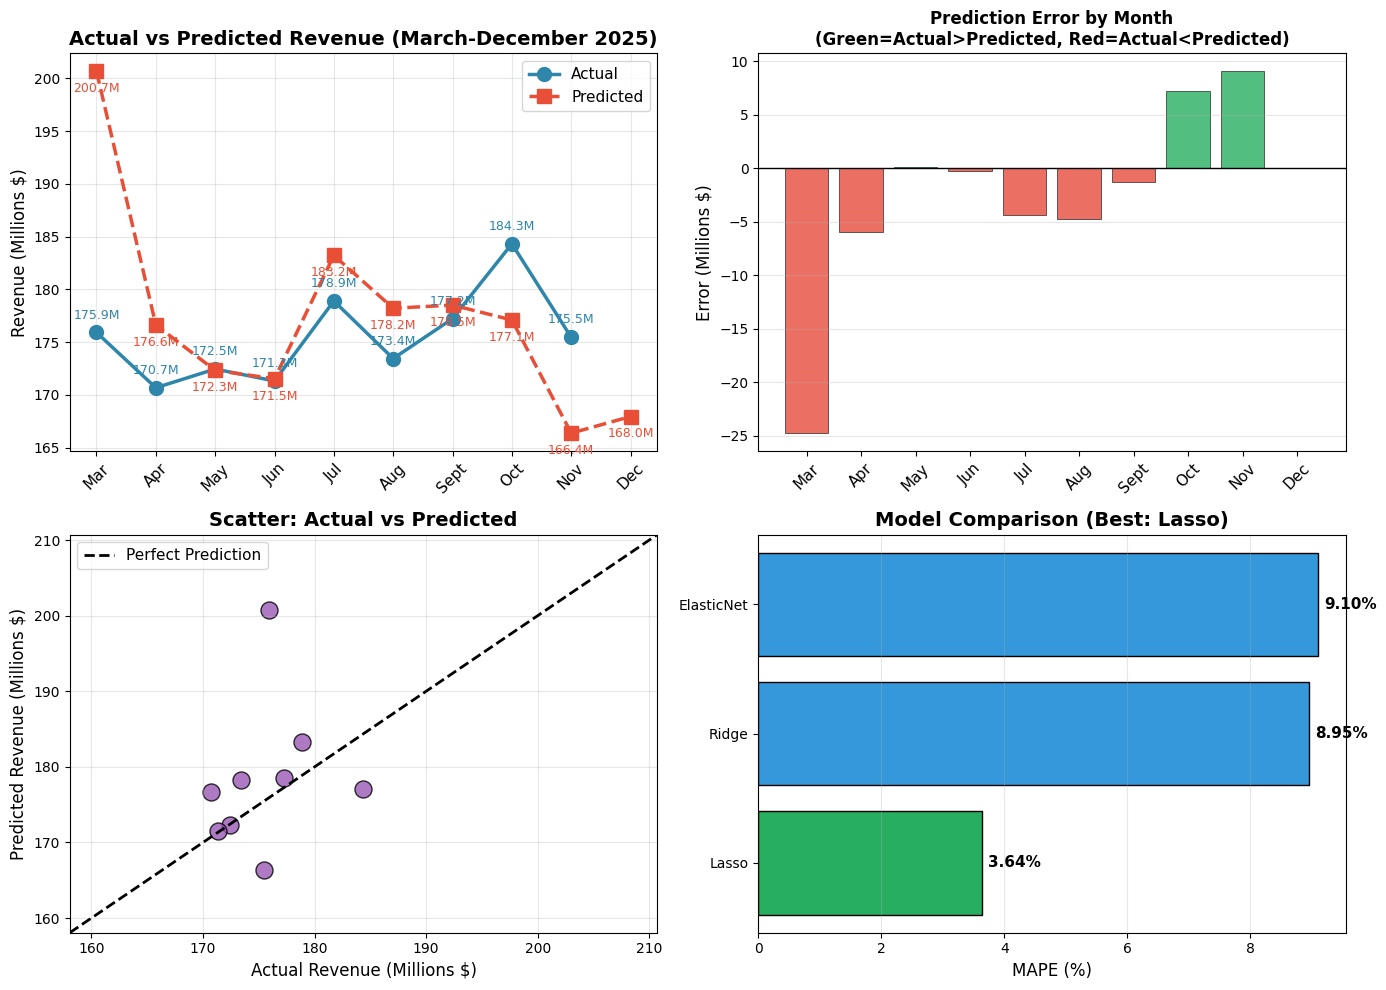


✅ Visualization saved to: revenue_forecast_results.png


In [30]:
# Visualization: Predicted vs Actual
print('\n' + '='*80)
print('VISUALIZATION: PREDICTED VS ACTUAL')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Line Chart: Actual vs Predicted
ax1 = axes[0, 0]
months = test_data['month'].values
x_pos = range(len(months))

# Fill NaN actuals with predicted for visualization
actual_display = test_data['actual_revenue'].values / 1e6  #.fillna(test_data['predicted_revenue']).values / 1e6
predicted_display = test_data['predicted_revenue'].values / 1e6

ax1.plot(x_pos, actual_display, marker='o', label='Actual', color='#2E86AB', linewidth=2.5, markersize=10)
ax1.plot(x_pos, predicted_display, marker='s', label='Predicted', color='#E94F37', linewidth=2.5, linestyle='--', markersize=10)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months, rotation=45, fontsize=11)
ax1.set_ylabel('Revenue (Millions $)', fontsize=12)
ax1.set_title('Actual vs Predicted Revenue (March-December 2025)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Add value labels
for i, (a, p) in enumerate(zip(actual_display, predicted_display)):
    ax1.annotate(f'{a:.1f}M', (i, a), textcoords='offset points', xytext=(0, 10), ha='center', fontsize=9, color='#2E86AB')
    ax1.annotate(f'{p:.1f}M', (i, p), textcoords='offset points', xytext=(0, -15), ha='center', fontsize=9, color='#E94F37')

# 2. Bar Chart: Error by Month
ax2 = axes[0, 1]
errors = (test_data['actual_revenue'] - test_data['predicted_revenue']).fillna(0) / 1e6
colors = ['#27AE60' if e >= 0 else '#E74C3C' for e in errors]
ax2.bar(x_pos, errors, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(months, rotation=45, fontsize=11)
ax2.set_ylabel('Error (Millions $)', fontsize=12)
ax2.set_title('Prediction Error by Month\n(Green=Actual>Predicted, Red=Actual<Predicted)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Scatter Plot: Actual vs Predicted
ax3 = axes[1, 0]
mask = ~pd.isna(test_data['actual_revenue'])
if mask.sum() > 0:
    actual_vals = test_data.loc[mask, 'actual_revenue'].values / 1e6
    pred_vals = test_data.loc[mask, 'predicted_revenue'].values / 1e6

    ax3.scatter(actual_vals, pred_vals, s=150, c='#9B59B6', edgecolor='black', linewidth=1, alpha=0.8)

    # Perfect prediction line
    min_val = min(min(actual_vals), min(pred_vals)) * 0.95
    max_val = max(max(actual_vals), max(pred_vals)) * 1.05
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')

    ax3.set_xlabel('Actual Revenue (Millions $)', fontsize=12)
    ax3.set_ylabel('Predicted Revenue (Millions $)', fontsize=12)
    ax3.set_title('Scatter: Actual vs Predicted', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=11)
    ax3.grid(alpha=0.3)
    ax3.set_xlim(min_val, max_val)
    ax3.set_ylim(min_val, max_val)

# 4. Model Comparison Bar Chart
ax4 = axes[1, 1]
model_names = list(results.keys())
mape_vals = [results[m]['MAPE'] for m in model_names]
colors_model = ['#27AE60' if m == best_model_name else '#3498DB' for m in model_names]
ax4.barh(model_names, mape_vals, color=colors_model, edgecolor='black', linewidth=1)
ax4.set_xlabel('MAPE (%)', fontsize=12)
ax4.set_title(f'Model Comparison (Best: {best_model_name})', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(mape_vals):
    ax4.text(v + 0.1, i, f'{v:.2f}%', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('revenue_forecast_results.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n✅ Visualization saved to: revenue_forecast_results.png')

In [31]:
# Feature Importance Analysis
print('\n' + '='*80)
print('FEATURE IMPORTANCE (Simple, Explainable Features)')
print('='*80)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': best_model.coef_,
    'Abs_Coefficient': np.abs(best_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

feature_importance['Importance_%'] = (feature_importance['Abs_Coefficient'] / feature_importance['Abs_Coefficient'].sum()) * 100
feature_importance['Direction'] = feature_importance['Coefficient'].apply(lambda x: '📈 Positive' if x > 0 else '📉 Negative')

print('\n🏆 Top 15 Most Important Features:')
print('-'*90)
for i, row in feature_importance.head(15).iterrows():
    direction = '📈' if row['Coefficient'] > 0 else '📉'
    print(f'{direction} {row["Feature"]:40} | Coef: {row["Coefficient"]:>15,.0f} | Importance: {row["Importance_%"]:>5.1f}%')

# Summary by category
print('\n📊 Feature Importance by Business Category:')
category_map = {
    'YoY': ['same_month_revenue_ly', 'revenue_lag_12', 'yoy_growth_rate', 'signed_density_yoy_change'],
    'Trend': ['revenue_avg_3m', 'revenue_avg_6m', 'trend_direction', 'mom_growth'],
    'Pipeline': ['signed_density', 'unsigned_density', 'pipeline_density', 'total_forecast_density'],
    'Momentum': ['revenue_macd', 'signed_momentum'],
    'Ratios': ['signed_to_total_ratio', 'avg_prob_pct_feature', 'pipeline_coverage'],
    'Lags': ['revenue_lag_1', 'revenue_lag_3', 'signed_density_lag_1'],
    'Time': ['remaining_months', 'quarter', 'is_q4', 'is_quarter_end']
}

for cat, features in category_map.items():
    cat_importance = feature_importance[feature_importance['Feature'].isin(features)]['Importance_%'].sum()
    print(f'   {cat:12}: {cat_importance:>5.1f}%')


FEATURE IMPORTANCE (Simple, Explainable Features)

🏆 Top 15 Most Important Features:
------------------------------------------------------------------------------------------
📈 signed_density                           | Coef:      35,158,583 | Importance:  15.3%
📉 signed_momentum                          | Coef:     -28,048,820 | Importance:  12.2%
📈 quarter                                  | Coef:      26,482,822 | Importance:  11.5%
📈 remaining_months                         | Coef:      26,332,357 | Importance:  11.5%
📈 signed_density_lag_1                     | Coef:      24,011,934 | Importance:  10.5%
📉 signed_delta_1m                          | Coef:     -20,116,615 | Importance:   8.8%
📉 signed_to_total_ratio                    | Coef:     -12,188,669 | Importance:   5.3%
📉 revenue_lag_1                            | Coef:      -9,419,711 | Importance:   4.1%
📉 revenue_avg_6m                           | Coef:      -7,087,299 | Importance:   3.1%
📉 unsigned_density             

In [15]:
# Summary
print('\n' + '='*80)
print('SUMMARY')
print('='*80)
print(f'''
✅ MODEL: {best_model_name} (selected based on lowest MAPE)
✅ TRAINING DATA: 2023-2024 ({len(train_data)} samples)
✅ TEST DATA: March-December 2025 ({len(test_data)} months)
✅ FEATURES: {len(feature_cols)} simple, explainable features

📊 FEATURE CATEGORIES (Business-Friendly):
   • YoY Features: Compare to same time last year
   • Trend Features: Recent 3-month and 6-month averages
   • Pipeline Density: Pipeline per remaining month
   • Momentum: MACD-style indicators (acceleration/deceleration)
   • Ratios: Simple business ratios
   • Deltas: Month-to-month changes

🔧 CORRECTED SIMULATION LOGIC:
   • YoY Fill with SOURCE MAPPING:
     - revenue_lag_12 ← actual_revenue from same month last year
     - same_month_revenue_ly ← actual_revenue from same month last year
     - Example: April 2025's revenue_lag_12 = April 2024's actual_revenue
     - NO MORE "lag of lag" issue!

   • Forward Fill: Uses last known actual value
   • EWM(6): Rolling 6-month exponential weighted mean
     Dynamically updates with each simulated month

📈 PERFORMANCE:
   • MAE:  ${mae:,.0f}
   • MAPE: {mape:.2f}%
   • RMSE: ${rmse:,.0f}

📝 KEY FIX:
The critical issue was that YoY features were using the FEATURE value from
last year instead of the SOURCE value. For revenue_lag_12 (which represents
"revenue from 12 months ago"), we now correctly use last year's actual_revenue,
not last year's revenue_lag_12 (which would give 2023 data instead of 2024).
''')


SUMMARY

✅ MODEL: Lasso (selected based on lowest MAPE)
✅ TRAINING DATA: 2023-2024 (22 samples)
✅ TEST DATA: March-December 2025 (10 months)
✅ FEATURES: 25 simple, explainable features

📊 FEATURE CATEGORIES (Business-Friendly):
   • YoY Features: Compare to same time last year
   • Trend Features: Recent 3-month and 6-month averages
   • Pipeline Density: Pipeline per remaining month
   • Momentum: MACD-style indicators (acceleration/deceleration)
   • Ratios: Simple business ratios
   • Deltas: Month-to-month changes

🔧 CORRECTED SIMULATION LOGIC:
   • YoY Fill with SOURCE MAPPING:
     - revenue_lag_12 ← actual_revenue from same month last year
     - same_month_revenue_ly ← actual_revenue from same month last year
     - Example: April 2025's revenue_lag_12 = April 2024's actual_revenue
     - NO MORE "lag of lag" issue!
   
   • Forward Fill: Uses last known actual value
   • EWM(6): Rolling 6-month exponential weighted mean
     Dynamically updates with each simulated month

📈 PE